# 2.2 간단한 Retrieval 에이전트 (feat. PDF 전처리 꿀팁)

- 앞 페이지 그래프: `START` -> `generate` -> `END`
- 여기서는 RAG 에이전트 생성: `START` -> `retrieve` -> `generate` -> `END`

- 추가로 [zerox](https://zerox.ai/)를 통해 PDF 파일을 전처리하는 방법을 알아봄


여기서는 테스트 문서를 소득세법을 사용함

우리는 추가로 35페이지의 표가 잘 인식되는지도 확인할 것임

`PyPDFLoader`를 사용해 문서를 읽어옴

In [1]:
from langchain_community.document_loaders import PyPDFLoader

# 공식문어에서는 비동기 lazy_load를 사용하여 문서를 읽음
pdf_file_path = "./documents/income_tax.pdf"
loader = PyPDFLoader(pdf_file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [5]:
pages[35]
# 표가 이미지여서 파싱을 못함

Document(metadata={'source': './documents/income_tax.pdf', 'page': 35}, page_content='법제처                                                            36                                                       국가법령정보센터\n소득세법\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 “퇴직소득 산출세액”이라 한다\n)으로 한다.<개정 2013. 1. 1., 2014. 12. 23.>\n1. 해당 과세기간의 퇴직소득과세표준에 제1항의 세율을 적용하여 계산한 금액\n2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액\n3. 삭제<2014. 12. 23.>\n[전문개정 2009. 12. 31.]\n \n           제2관 세액공제 <개정 2009. 12. 31.>\n \n제56조(배당세액공제) ① 거주자의 종합소득금액에 제17조제3항 각 호 외의 부분 단서가 적용되는 배당소득금액이 합\n산되어 있는 경우에는 같은 항 각 호 외의 부분 단서에 따라 해당 과세기간의 총수입금액에 더한 금액에 해당하는\n금액을 종합소득 산출세액에서 공제한다. <개정 2009. 12. 31.>\n② 제1항에 따른 공제를 “배당세액공제”라 한다.<개정 2009. 12. 31.>\n③ 삭제<2003. 12. 30.>\n④ 제1항을 적용할 때 배당세액공제의 대상이 되는 배당소득금액은 제14조제2항의 종합소득과세표준에 포함된 배\n당소득금액으로서 이자소득등의 종합과세기준금액을 초과하는 것으로 한다.<개정 2009. 12. 31.>\n⑤ 삭제<2006. 12. 30.>\n⑥ 배당세액공제액의 계산 등에 필요한 사항은 대통령령으로 정한다.<개정 2009. 12. 31.>\n[제목개정 2009. 12. 31.]\n \n제56조의2(기장세액공제) ① 제160조제3항에 따른 간편장부대상자가 제70조

한가지 대안은 chatgpt를 사용하여 표를 파싱하는 방법이 있다.   

다른 방법은 py-zerox를 사용하여 ocr, llm으로 파싱하는 방법

데이터 전처리를 위한 [py-zerox](https://www.piwheels.org/project/py-zerox/) 패키지를 설치

In [3]:
# %pip install -q py-zerox

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

- 노트북에서 `asyncio`를 사용하기 위해 `nest_asyncio`를 설치합니다

In [6]:
%pip install -q nest_asyncio


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import nest_asyncio

nest_asyncio.apply()

- `py-zerox`를 통해 pdf파일을 전처리합니다
- 강의에서는 `OpenAI`를 사용하지만, 아래 예제는 `AzureOpenAI`를 사용합니다

In [9]:
from pyzerox import zerox
import os
import json
import asyncio

### 모델 설정 (Vision 모델만 사용) 참고: https://docs.litellm.ai/docs/providers ###

## 일부 모델에 필요할 수 있는 추가 모델 kwargs의 자리 표시자
kwargs = {}

## Vision 모델에 사용할 시스템 프롬프트
custom_system_prompt = None

model = "azure/gpt-4o-2024-11-20"
os.environ["AZURE_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")
os.environ["AZURE_API_BASE"] = os.getenv("AZURE_OPENAI_ENDPOINT")
os.environ["AZURE_API_VERSION"] = "2024-08-01-preview"  # "2023-05-15"


# 메인 비동기 진입점을 정의합니다
async def main():
    file_path = "./documents/income_tax.pdf"  ## 로컬 파일 경로 및 파일 URL 지원

    ## 일부 페이지 또는 전체 페이지를 처리
    select_pages = (
        None  ## 전체는 None, 특정 페이지는 int 또는 list(int) 페이지 번호 (1부터 시작)
    )

    output_dir = "./documents"  ## 통합된 마크다운 파일을 저장할 디렉토리
    result = await zerox(
        file_path=file_path,
        model=model,
        output_dir=output_dir,
        custom_system_prompt=custom_system_prompt,
        select_pages=select_pages,
        **kwargs
    )
    return result


# 메인 함수를 실행합니다:
result = asyncio.run(main())

# 마크다운 결과를 출력합니다
print(result)

ZeroxOutput(completion_time=1066981.204, file_name='income_tax', input_tokens=126350, output_tokens=159128, pages=[Page(content='```markdown\n# 소득세법\n\n[시행 2025. 1. 1.] [법률 제20615호, 2024. 12. 31., 일부개정]  \n기획재정부 (세제실세제관(양도소득세)) 044-215-4312  \n기획재정부 (소득세제과(근로소득)) 044-215-4216  \n기획재정부 (금융세제과(이자소득, 배당소득)) 044-215-4233  \n기획재정부 (소득세제과(사업소득, 기타소득)) 044-215-4217  \n\n---\n\n## 제1장 총칙\n\n### 제1조(목적)  \n이 법은 개인의 소득에 대하여 소득의 성격과 납세자의 부담능력 등에 따라 적정하게 과세함으로써 조세부담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 한다.  \n[본조신설 2009. 12. 31.]  \n[종전 제1조는 제2조로 이동 <2009. 12. 31.>]  \n\n### 제2조(정의)  \n① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2010. 12. 27., 2014. 12. 23., 2018. 12. 31.>  \n1. "거주자"란 국내에 주소를 두거나 183일 이상의 거소(居所)를 둔 개인을 말한다.  \n2. "비거주자"란 거주자가 아닌 개인을 말한다.  \n3. "내국법인"이란 「법인세법」 제2조제1호에 따른 내국법인을 말한다.  \n4. "외국법인"이란 「법인세법」 제2조제3호에 따른 외국법인을 말한다.  \n5. "사업자"란 사업소득이 있는 거주자를 말한다.  \n6. 제1항에 따른 주소·거소와 거주자·비거주자의 구분은 대통령령으로 정한다.  \n[본조신설 2009. 12. 31.]  \n\n---\n\n### 제2조의2(납세의무)  \n① 다음 각 호의 어느 하나에 해당하는 개인은 이 법에 따라 각자의 

- zerox를 활용한 전처리 후 생성된 마크다운 파일을 LangGraph에서 활용하기 위해 [unstructured](https://unstructured.io/) 패키지를 설치합니다
- `UnstructuredMarkdownLoader`를 사용해 전처리된 데이터를 확인합니다
    - `loader`활용 시 테이블 구조가 사라지는 것을 확인할 수 있습니다

In [10]:
%pip install -q "unstructured[md]" nltk


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500, chunk_overlap=100, separators=["\n\n", "\n"]
)

In [12]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader

markdown_path = "./documents/income_tax.md"
loader = UnstructuredMarkdownLoader(markdown_path)
document_list = loader.load_and_split(text_splitter)

In [13]:
document_list[43]

Document(metadata={'source': './documents/income_tax.md'}, page_content='제51조(추가공제) ① 제50조에 따른 기본공제대상이 되는 사람(이하 “기본공제대상자”라 한다)이 다음 각 호의 어느 하나에 해당하는 경우에는 거주자의 해당 과세기간 종합소득금액에서 기본공제 외에 각 호별로 정해진 금액을 추가로 공제한다. 다만, 제3호와 제6호에 모두 해당되는 경우에는 제6호를 적용한다. <개정 2013. 1. 1., 2014. 1. 1.> 1. 70세 이상인 사람(이하 “경로우대자”라 한다)의 경우 1명당 연 100만원 2. 대통령령으로 정하는 장애인(이하 “장애인”이라 한다)의 경우 1명당 연 200만원 3. 해당 거주자(해당 과세기간에 종합소득과세표준을 계산할 때 작성한 종합소득금액이 3천만원 이하인 거주자로 한정한다)의 배우자가 없는 여성으로서 제50조제1항제3호에 따른 부양가족이 있는 세대주이거나 배우자가 있는 여성인 경우 연 50만원 4. 삭제 <2014. 1. 1.> 5. 삭제 <2014. 1. 1.> 6. 해당 거주자가 배우자가 없는 사람으로서 기본공제대상자인 직계비속 또는 입양자가 있는 경우 연 100만원 ② 제1항에 따른 공제를 “추가공제”라 한다. ③ 기본공제와 추가공제를 “인적공제”라 한다. <신설 2014. 1. 1.> ④ 인적공제의 합계액이 종합소득금액을 초과하는 경우 그 초과하는 공제액은 없는 것으로 한다. <신설 2014. 1. 1.> [전문개정 2009. 12. 31.]\n\n제51조의2 삭제 <2014. 1. 1.>\n\n제51조의3(연금보험료공제) ① 종합소득이 있는 거주자가 공적연금 관련법에 따른 기여금 또는 개인부담금(이하 “연금보험료”라 한다)을 납입한 경우에는 해당 과세기간의 종합소득금액에서 그 과세기간에 납입한 연금보험료를 공제한다. <개정 2013. 1. 1., 2014. 1. 1.> 1. 삭제 <2014. 1. 1.> 2. 삭제 <2014. 1. 1.> ③ 제1항에 따

- 마크다운 테이블을 활용하기 위해 `.md` -> `.txt`로 변환합니다

In [14]:
%pip install -q markdown html2text beautifulsoup4


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import markdown
from bs4 import BeautifulSoup

text_path = "./documents/income_tax.txt"

# 마크다운 파일을 읽어옵니다
with open(markdown_path, "r", encoding="utf-8") as md_file:
    md_content = md_file.read()

# 마크다운 콘텐츠를 HTML로 변환합니다
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합니다
soup = BeautifulSoup(html_content, "html.parser")
text_content = soup.get_text()

# 추출한 텍스트를 텍스트 파일로 저장합니다
with open(text_path, "w", encoding="utf-8") as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")

Markdown converted to plain text successfully!


- `TextLoader`를 사용해 전처리된 데이터를 확인합니다

In [16]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(text_path)
document_list = loader.load_and_split(text_splitter)

In [17]:
document_list[39]

Document(metadata={'source': './documents/income_tax.txt'}, page_content='A: 기준소득금액\nB: 전항에 따라 필요경비에 산입하는 기부금\nC: 이월결손금\n```\n나. 종교단체에 기부한 금액이 없는 경우\n```\n필요경비 산입한도액 = [(A - (B + C)) × 100분의 30]  \nA: 기준소득금액\nB: 전항에 따라 필요경비에 산입하는 기부금\nC: 이월결손금\n```\n4) 제2항제1호 및 제3항제1호 외의 기부금은 해당 과세기간의 사업소득금액을 계산할 때 필요경비에 산입하지 아니한다. <개정 2020. 12. 29.>  \n5) 사업자가 해당 과세기간에 지출하는 기부금 중 제2항제2호 및 제3항제2호에 따른 필요경비 산입한도액을 초과하여 필요경비에 산입하지 아니한 특례기부금 및 일반기부금의 금액(제59조의4제4항에 따라 종합소득세 신고 시 제약을 제외하는 기부금의 금액은 제외한다)은 대통령령으로 정하는 바에 따라 해당 과세기간의 다음 과세기간 개시일부터 10년 이내에 끝나는 각 과세기간에 이월하여 필요경비에 산입할 수 있다. <신설 2019. 12. 31., 2022. 12. 31.>  \n6) 제2항 및 제3항을 적용할 때 제50조제1항제2호 및 제3호에 해당하는 사람(나의 제한을 받지 아니하며, 다른 거주자의 기준금제를 적용받는 사람은 제외한다)이 지급한 기부금은 해당 사업자의 기부금에 포함한다. <개정 2010. 12. 27., 2016. 12. 20., 2018. 12. 31., 2019. 12. 31., 2020. 12. 29.>  \n7) 제1항부터 제6항까지에서 규정한 사항 외에 기부금의 계산, 제출서류, 기부금을 받는 단체의 관리 등 기부금의 필요경비 산입에 관하여 필요한 사항은 대통령령으로 정한다. <신설 2018. 12. 31., 2019. 12. 31., 2020. 12. 29.>  \n법제처 24 국가법령정보센터\n소득세법\n[전문개정 2009. 12. 31.]\

- 전처리된 데이터를 벡터화하기 위해 [Chroma](https://docs.trychroma.com/getting-started)를 활용합니다
- LangChain과의 호환을 위해 [langchain-chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma/)를 설치합니다

In [18]:
%pip install -q langchain-chroma


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [20]:
from langchain_chroma import Chroma

vector_store = Chroma.from_documents(
    documents=document_list,
    embedding=embeddings,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
)

In [21]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [26]:
query = "연봉 5천만원 직장인의 소득세는?"

In [27]:
retriever.invoke(query)

[Document(metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
 Document(metadata={'source': './documents/income_tax.txt'}, page_content='이자소득에 대해서는 다음과 같이 규정하는 세율\n가. 삭제<2017. 12. 19.>\n나. 비영업대금의 이익에 대해서는 100분의 25. 단, ‘온라인투자연계금융업 및 이용자 보호에 관한 법률’ 제 법 금융위원회에 등록한 온라인투자연계금융업자를 통해 지급받는 

- `state`를 선언하고 에이전트를 생성합니다
- 2.1강에서 진행한 것과 다르게 `messages` 커스텀 변수들을 선언합니다
    - `query`는 사용자의 질문을 저장하는 용도로 사용합니다
    - `context`는 벡터 스토어에서 추출한 데이터를 저장하는 용도로 사용합니다
    - `answer`는 최종 응답을 저장하는 용도로 사용합니다

In [1]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document


class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [2]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

- `retrieve` 노드는 사용자의 질문을 받아 벡터 스토어에서 추출한 데이터를 반환합니다

In [3]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {"context": docs}  # 검색된 문서를 포함한 state를 반환합니다.

- `LangChain`의 `hub`를 통해 미리 정의된 RAG 프롬프트를 활용합니다
    - `hub`에는 이미 검증된 프롬프트들이 많기 때문에 프로젝트 진행 시 좋은 시작점이 됩니다
    - `hub`에서 프롬프트를 찾아보고, 동작을 확인한 후 커스텀 하는 것을 권장합니다

In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model="gpt-4o")

/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [5]:
def generate(state: AgentState) -> AgentState:
    """
    사용자의 질문과 검색된 문서를 기반으로 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답이 추가된 state를 반환합니다.
    """
    context = state["context"]  # state에서 검색된 문서를 추출합니다.
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.
    rag_chain = prompt | llm  # RAG 프롬프트와 LLM을 연결하여 체인을 만듭니다.
    response = rag_chain.invoke(
        {"question": query, "context": context}
    )  # 질문과 문맥을 사용하여 응답을 생성합니다.
    return {"answer": response}  # 생성된 응답을 포함한 state를 반환합니다.

- `node`를 추가하고 `edge`로 연결합니다

In [6]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

In [7]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

In [8]:
graph = graph_builder.compile()

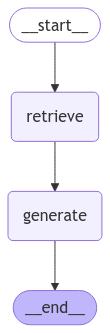

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- 병렬처리나 `conditional_edge`가 없는 경우 `add_sequence()`를 통해 순차적으로 동작하는 그래프를 생성할 수 있습니다

In [10]:
sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])

In [11]:
sequence_graph_builder.add_edge(START, "retrieve")
sequence_graph_builder.add_edge("generate", END)

In [12]:
sequence_graph = sequence_graph_builder.compile()

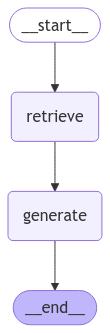

In [13]:
display(Image(sequence_graph.get_graph().draw_mermaid_png()))

In [22]:
initial_state = {"query": query}
graph.invoke(initial_state)

{'query': '연봉 5천만원 직장인의 소득세는?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(metadata={'source': './documents/income_tax.txt'}, page_content='이자소득에 대해서는 다음과 같이 규정하는 세율\n가. 삭제<2017. 12. 19.>\n나. 비영업대금의 이익에 대해서는 100분의 25. 단, ‘온라인투자연계금융업 및 이용자 보호